# <font color='#28B463'>LASSO REGRESSION

<br>

## <font color='#28B463'>Introduction

<br>
<b>Lasso Regression</b> (Least Absolute Shrinkage and Selection Operator, also known as L1 regularization) <b>is a regression analysis method that performs both regularization and variable selection</b>.

<br>
Robert Tibshirani introduced Lasso in 1996 <b>in order to improve the prediction accuracy and interpretability of regression models</b> by altering the model fitting process to select only a subset of the provided regressors for use in the final model rather than using all of them.

<br>
We said the the first reason is prediction <b>accuracy</b> : the OLS estimates often have low bias but large variance; prediction accuracy can sometimes be improved by shrinking or setting to zero some coefficients. By doing so we sacrifice a little bit of bias to reduce the variance of the predicted values and hence may improve the overall prediction accuracy.

<br>
The second reason is <b>interpretation : with a large number of predictors, we often would like to determine a smaller subset that exhibit the strongest effects</b>. The two standard techniques for improving the OLS estimates, subset selection and ridge regression, both have drawbacks. Subset selection provides interpretable models but can be extremely variable because it is a discrete process, regressors are either retained or dropped from the model. Small changes in the data can result in very different models being selected and this can reduce its prediction accuracy. Ridge regression is a continuous process that shrinks coefficients and hence is more stable: however, it doesn't set any coefficients to zero and hence doesn't give an easily interpretable model.

The simulations published in Tibshirani's paper <a href="http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=460FC4389D543251766F55D4ECA9433C?doi=10.1.1.35.7574&rep=rep1&type=pdf">Regression Shrinkage and Selection via the Lasso</a> suggest that <b>Lasso enjoys some of the favourable properties of both subset selection and ridge regression : it produces interpretable models like subset selection
and exhibits the stability of ridge regression</b>. 

<br>
Lasso is able to achieve both of these goals by forcing the sum of the absolute value of the regression coefficients to be less than a fixed value, which forces certain coefficients to be set to zero, effectively choosing a simpler model that does not include those coefficients. 
   

## <font color='#28B463'>Problems with OLS

<br>
Ordinary least squares (under CLRM assumptions) provides estimates of the regression coefficients that are unbiased and have minimum variance in the class of the other linear unbiased estimators :


<br>
<blockquote style="background-color: #f0f0f5">
$
\begin{align}
    \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} 
    &= \newline
    &= (\mathbf{X}^{\top}\mathbf{X})^{-1} \mathbf{X}^{\top}\mathbf{Y} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
        \text{the regressors have been standardized} \quad (\mathbf{X}^{\top}\mathbf{X} = \mathbf{R})
        \newline
    &= \mathbf{R}^{-1} \mathbf{X}^{\top}\mathbf{Y}
\end{align}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
\mathbf{E} \big[ \hat{\boldsymbol{\beta}}_\boldsymbol{OLS} \big] = \boldsymbol{\beta_{OLS}}
$
</blockquote>

<blockquote style="background-color: #f0f0f5">
$
\begin{align}
    \mathrm{V}(\hat{\boldsymbol{\beta}}_\boldsymbol{OLS}) 
    &= \newline
    &= \boldsymbol{\sigma^2} \ (\mathbf{X}^{\top}\mathbf{X})^{-1} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
        \text{the regressand too has been standardized} \quad (\boldsymbol{\sigma^2} = 1)
        \newline
    &= \mathbf{R}^{-1}
\end{align}
$
</blockquote>

<br>
This estimation procedure yields reliable estimates if $\ (\mathbf{X}^{\top}\mathbf{X}) \ $, when in the form of a correlation
matrix, is nearly a unit (identity) matrix. 

<br>
In the presence of multicollinearity, however, if $ \ (\mathbf{X}^{\top}\mathbf{X}) \ $ is not nearly a unit matrix and we are forced to treat the estimated regression function as a black box (multicollinearity does not reduce the predictive power or reliability of the model as a whole, it only affects calculations regarding individual predictors) or to drop regressors in order to prevent the issue. Both these alternatives are unsatisfactory if the original intent was to use the estimated predictor for control and optimization. 


In [1]:
# SETUP : importing

import numpy as np
import math
import pandas as pd

from sklearn.datasets import load_boston

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import sklearn.linear_model as lm
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as mtr
from scipy import stats

import utilcompute as uc
import utilplot as up
import preprocessing as pre
import regularized_regression as rr

from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM',    # per capita crime rate by town
    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',   # proportion of non-retail business acres per town
    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',     # nitric oxides concentration (parts per 10 million)
    'RM',      # average number of rooms per dwelling
    'AGE',     # proportion of owner-occupied units built prior to 1940
    'DIS',     # weighted distances to five Boston employment centres
    'RAD',     # index of accessibility to radial highways
    'TAX',     # full-value property-tax rate per $10,000
    'PTRATIO', # pupil-teacher ratio by town
    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',   # % lower status of the population
    'MEDV'     # median value of owner-occupied homes in $1000's
]


In [3]:
# SETUP : printing aggregated info

#s = uc.summary(df)
#print(s)

In [4]:
target = 'MEDV'

if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [5]:
#fig, axs = plt.subplots(nrows = len(features), ncols = 1, figsize=(20, 4 * len(features)))    

#for (f_index, f) in enumerate(features) :
#    ax = axs[f_index]
#    subset = df[f]        
#    sns.distplot(a= subset, ax = ax, label = f)   
#    ax.axvline(x = subset.mean(), linestyle='--')
#    ax.legend(loc='best') 

#plt.tight_layout()
#plt.show()

In [6]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [7]:
# SETUP : data split

train_perc = 0.8
delimiter = int(len(df) * train_perc)

df_train = pd.DataFrame( df[:delimiter] ) # train + validation
df_test = pd.DataFrame( df[delimiter:] )  # test


## <font color='#28B463'>Assumptions

<br>
The assumptions are the same as those used in regular multiple regression: linearity, homoscedasticity, and independence.


## <font color='#28B463'>Standardization

<br>
In lasso regression, the first step is to standardize the independent variables by subtracting their means and dividing by their standard deviations :

<br>
$
    \quad
    \boldsymbol{X_i}^{\star}  = \dfrac {\boldsymbol{X_i} – \mu_X} {\sigma_X}
$

<br>
This would cause a change in notation, since we should indicate whether the variables in a particular formula are standardized or not; to keep things simple, in this notebook we will make the following general statement and then forget about notation.

<br>
As far as standardization is concerned, <b>all lasso regression calculations are based on standardized variables</b>.

In [8]:
# DATA PREPROCESSING (TRAIN + VALIDATION) : features transformation

#df_sk = pd.DataFrame()
#for (f_index, f) in enumerate(features):
#    subset = df_train[f]
#    log_modulus_transform = np.sign(subset) * np.log10(np.abs(subset) + 1)
#    if (abs(stats.skew(log_modulus_transform)) < abs(stats.skew(subset))) :
        #df_sk[f] = np.sqrt(df_train[f])
#        df_sk[f] = log_modulus_transform
#    else:
#        df_sk[f] = subset
#df_sk[target] =  df_train[target]

excluded_features = ['CHAS']
included_features = [f for f in features if (f not in excluded_features)]

#df_cnt = pre.center(df = df_sk, included = features, excluded = target)
#df_std = pre.standardize(df = df_sk, included = features, excluded = target)

df_cnt = pre.center(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std = pre.standardize(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))


In [9]:
# DATA PREPROCESSING (TEST) : features transformation

#df_sk_test = pd.DataFrame()
#for (f_index, f) in enumerate(features):
#    df_sk_test[f] = np.sqrt(df_test[f])
#df_sk_test[target] =  df_test[target]

#df_cnt_test = pre.center(df = df_sk_test, included = features, excluded = target)
#df_std_test = pre.standardize(df = df_sk_test, included = features, excluded = target)

df_cnt_test = pre.center(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std_test = pre.standardize(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))


### <font color='#28B463'>Impact on the transformed features

<br>

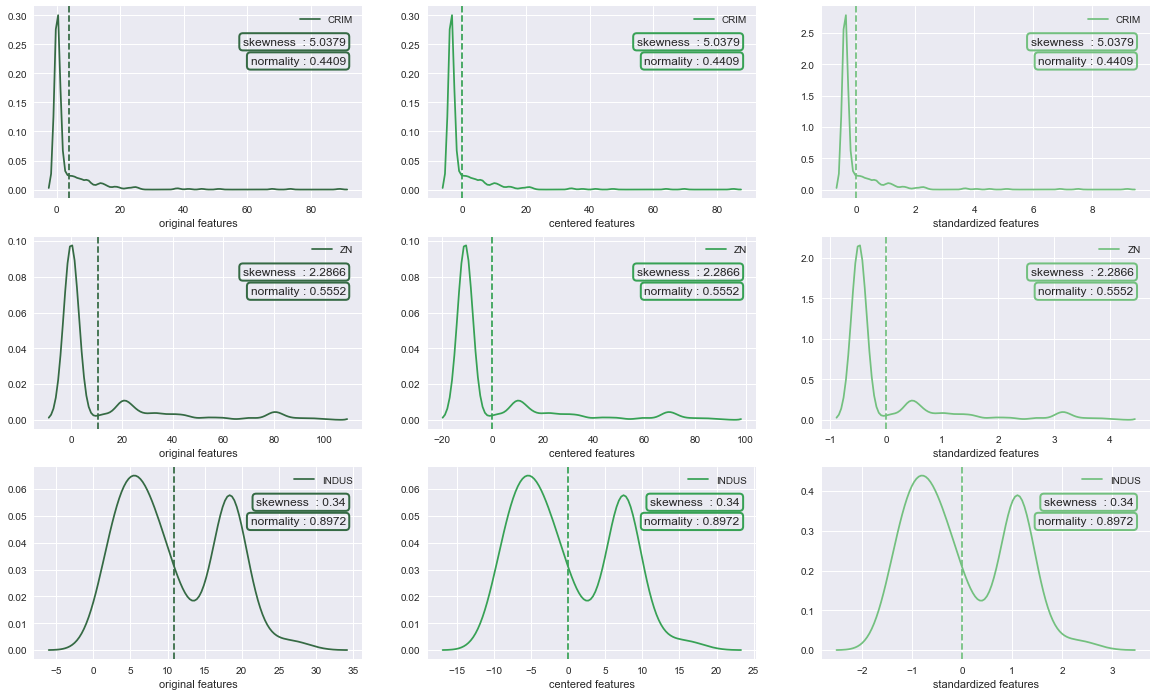

In [10]:
plot_list = [
    { 'df' : df_train, 'xlabel' : 'original features',     'legend_loc' : 'best'},
    #{ 'df' : df_sk,    'xlabel' : 'un-skewed features',    'legend_loc' : 'best'},
    { 'df' : df_cnt,   'xlabel' : 'centered features',     'legend_loc' : 'best'},
    { 'df' : df_std,   'xlabel' : 'standardized features', 'legend_loc' : 'best'}
]

visualized_features = included_features[:3]

n_rows = len(visualized_features)
n_cols = len(plot_list)
fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(20, 4 * n_rows ))    
pal = sns.color_palette("Greens_d", n_cols)

p = 0
for (pl_index, pl_dict) in enumerate(plot_list):      
    for (f_index,f) in enumerate(visualized_features) :
        ax = axs[f_index][pl_index] 
        subset = pl_dict['df'][f]       
        
        skewness = round(stats.skew(subset),4)
        normality = round(stats.shapiro(subset)[0],4)
        
        sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = f)   
        ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
        
        ax.text(x = 0.95, y = 0.8, horizontalalignment='right', s = ('skewness  : {0}'.format(skewness)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))
        ax.text(x = 0.95, y = 0.7, horizontalalignment='right', s = ('normality : {0}'.format(normality)),  
            transform = ax.transAxes, bbox = dict(boxstyle = "round, pad=0.3", fill = False, ec = pal[p], lw = 2))        
        
        ax.set_xlabel(pl_dict['xlabel'])
        ax.legend(loc = pl_dict['legend_loc'])
    p += 1
        

#plt.tight_layout()
plt.show()


### <font color='#28B463'>Impact on the VIF

<br>

In [11]:
vif_list = [
    {'df' : df_train, 'features' : features, 'label' : 'original'},
    {'df' : df_cnt,   'features' : features, 'label' : 'centered'},
    {'df' : df_std,   'features' : features, 'label' : 'standardized'}
]

template = "{0:<20}:{1:>10}" 
   
for vl in vif_list:    
    vif_dict = uc.compute_vif(df = vl['df'], features = vl['features'])
    print('VIF ({0})'.format(vl['label']))
    print()
    for (key, value) in vif_dict.items():
        print(template.format(key, round(value,4)))
    print()
    print()


VIF (original)

CRIM                :    2.0418
ZN                  :    3.0296
INDUS               :   15.5406
CHAS                :    1.1574
NOX                 :   77.0569
RM                  :   74.3479
AGE                 :   21.0854
DIS                 :   15.0748
RAD                 :    15.361
TAX                 :   65.6476
PTRATIO             :   85.5914
B                   :   19.3088
LSTAT               :   11.3059


VIF (centered)

CRIM                :    1.7513
ZN                  :     2.456
INDUS               :    4.3122
CHAS                :    1.0798
NOX                 :    4.4764
RM                  :    1.9463
AGE                 :    2.9617
DIS                 :    4.0246
RAD                 :     7.678
TAX                 :    9.6658
PTRATIO             :    1.8491
B                   :     1.345
LSTAT               :    3.0057


VIF (standardized)

CRIM                :    1.7513
ZN                  :     2.456
INDUS               :    4.3122
CHAS            

In [12]:
linear_list = [
    { 'df' : df_train,     'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'original' },
    #{ 'df' : df_sk,     'linear_model_name' : 'LinearRegression', 
    # 'linear_model_args' : {'fit_intercept' : True}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'centered' },
    { 'df' : df_std, 'linear_model_name' : 'LinearRegression', 
     'linear_model_args' : {'fit_intercept' : True}, 'note' : 'standardized'}    
]

results = pd.DataFrame()

for l in linear_list:
    results_temp = uc.compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        linear_model_name = l['linear_model_name'], 
        linear_model_args = l['linear_model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)

#print(results[['note','intercept', 'err_test']])

## <font color='#28B463'>Derivation

<br>
From the previous notebooks we know that the coefficients estimates are found by minimizing a so-called objective (or cost) function; here a comparison of this cost function in the context of OLS (residual sum of squares) and Lasso Regression (penalized sum of squares) :


<br>
<blockquote style="background-color: #f0f0f5">
$
    \begin{align}
        S_{OLS}(\hat{\boldsymbol{\beta}}) 
        &= \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}           
    \end{align}
$
</blockquote>

<br>
$
    \qquad \quad
    \begin{align}
        S_{L}(\hat{\boldsymbol{\beta}})    
        &= 
        \newline
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            \quad \text{subject to } \quad \sum _{i=1}^{p} \mid \hat{\boldsymbol{\beta}} \mid \leq t
        \newline        
        &= 
            S_{OLS}(\hat{\boldsymbol{\beta}}) 
            + \boldsymbol{k} \sum _{j=1}^{p} \mid {\hat{\boldsymbol{\beta}}_\boldsymbol{j}} \mid
        \newline
        &= 
            \sum _{i=1}^{N}(\boldsymbol{\mathbf{Y}_i} - \boldsymbol{\mathbf{X}_i}^{\top} \hat{\boldsymbol{\beta}})^{2}
            + \boldsymbol{k} \sum _{j=1}^{p} \mid {\hat{\boldsymbol{\beta}}_\boldsymbol{j}} \mid
    \end{align}
$


<b>In terms of the cost function, the only difference between Ridge and Lasso is that the former applies regularization through L2 norm ($ \ {\lVert \hat{\boldsymbol{\beta}}_\boldsymbol{j} \rVert}_2^2 = \ {\hat{\boldsymbol{\beta}}_\boldsymbol{j}}^2 \ $), while the latter uses L1 norm ($ \ {\lVert \boldsymbol{\beta_j} \rVert}_1 = \ \mid \hat{\boldsymbol{\beta}}_\boldsymbol{j} \mid\ $) </b>. Even though these two cost functions may at first look similar, the implication of a change in the norm used for regularization is deep, and we will see that the solutions obtained behave very differently.

### <font color='#28B463'>Differentiability and Analytic Form

<br>
The main consequence (computationally speaking) is that, unlike OLS and Ridge regression, the Lasso cost function is not differentiable (does not have a derivative) for any point where $ \ {\hat{\boldsymbol{\beta}}_\boldsymbol{j}} \ $ is equal to zero. 

<br>
Ordinary Least Squares and Ridge regression have what are called analytic solutions; in other words, it's possible to write down an explicit formula for the estimators. Generalized Linear Models, on the other hand, have only numerical solutions with iterative methods; we have algorithm that, when run sufficiently long enough should yield a solution with a reasonable accuracy.

<br>
<b>Lasso</b> falls somewhere in-between these two cases, as it <b>has a direct numerical solution; although we cannot write out an explicit analytic form, the algorithm is not iterative</b> and would yield the exact solution given a machine with infinite precision.

<br>
Though the lasso penalty is not differentiable, a wide variety of techniques from convex analysis and optimization theory have been developed to extremize such functions; these include subgradient methods, least-angle regression (LARS), and proximal gradient methods : 

<br>
<ul style="list-style-type:square">
    <li>
        <b>subgradient methods</b> are the natural generalization of traditional methods such as gradient descent and stochastic
        gradient descent to the case in which the objective function is not differentiable at all points
    </li>
    <br>
    <li>
         <b>LARS</b> is a method that is closely tied to lasso models, and in many cases allows them to be fit very efficiently,
         though it may not perform well in all circumstances
    </li>
    <br>
    <li>
        <b>proximal methods</b> have become popular because of their flexibility and performance and are an area of active
        research; the choice of method will depend on the particular lasso variant being used, the data, and the available
        resources. However, proximal methods will generally perform well in most circumstances
    </li>
</ul>


### <font color='#28B463'>Subdifferentiability

<br>
As we just said, the Lasso cost function does not have a derivative for any point where $ \ {\hat{\boldsymbol{\beta}}_\boldsymbol{j}} \ $ is equal to zero, but we can resort to the concept of subdifferentiability instead. In mathematics, <b>the subderivative, subgradient, and subdifferential generalize the derivative to functions which are not differentiable</b>.

<br>
Let $ \ f : H \rightarrow R \ $ be a real-valued convex function defined on an open interval of the real line. Such a function need not be differentiable at all points (for example, the absolute value function in zero); however, for any $ \ x_0 \ $ in the domain of the function we can draw a line which goes through the point $ \ (x_0, f(x_0)) \ $ and which is everywhere either touching or below the graph of $ \ f \ $. The slope of such a line is called a subderivative (because the line is under the graph of the function).

<br>
Formally, a subderivative of a convex function $ \ f : H \rightarrow R \ $ at a point $ \ x_0 \ $ in the open interval $ \ I \ $ is a real number $ \ c \ $ such that :

<br>
$
    \quad
    f(x) - f(x_0) \ \geq \ c \ (x - x_0) \quad \forall x \ \text{in} \ H
$

<br>
It's possible to show that the set of subderivatives at $ \ x_0 \ $ for a convex function is a non-empty closed interval $ \ [a, b] \ $, where $a$ and $b$ are the one-sided limits defined below (which are guaranteed to exist and satisfy $ \ a\leq b \ $) :

<br>
$
    \quad
    \begin{align}
        a &= \lim _{x \to x_0^-} \frac {f(x) - f(x_0)} {x - x_0}
        \newline \newline
        b &= \lim _{x \to x_0^+} \frac {f(x) - f(x_0)} {x - x_0}
    \end{align}
$

<br><br>
The set $ \ [a, b] \ $ of all the subderivatives is called the subdifferential of the function $ \ f \ $ at $ \ x_0 \ $; formally, the subdifferential at point $ \ x_0 \ $ in the domain of the function $ \ f \ $ is :

<br>
$
    \quad
    \partial \ (f)(x_0) 
    = \left\{ \ c \in R \quad \text{s.t.} \quad  c \ \leq \ \frac{f(x) - f(x_0)}{x - x_0} \quad \forall x \in I \ \right\}
$

<br>
More intuitively, the subdifferential of the function at that point is the set of all sub-slopes which are tangent to the
function at the point. Since the function is convex, when its subdifferential at $ \ x_0 \ $ contains exactly one subderivative, then the function is differentiable in that point.


### <font color='#28B463'>Subdifferentiability of functions of multiple variables

<br>
The concepts of subderivative and subdifferential can be generalized to functions of several variables : if $ \ f : H \rightarrow R \ $ is a real-valued convex function defined on a convex open set in the Euclidean space $ \ R^n \ $, a vector $ \ v \ $ in that space is called a subgradient at a point $ \ x_0 \ $ in $ \ H \ $ if for any $ \ x \in H \ $ we have : 

<br>
$
    \quad
    f(x) - f(x_0) \ \geq \ v \cdot (x - x_0) \quad \text{(where the dot denotes the dot product)}
$

<br>
The set of all subgradients of a function at a point is called the subdifferential at that point and is always a nonempty convex compact set :

<br>
$
    \quad
    \partial \ (f)(x_0) 
    = \left\{ \ v \in R^n \quad \text{s.t.} \quad  f(x_0) \ \geq \ f(x) + v^{\top}(x - x_0) \quad \forall x \in H \ \right\}
$

### <font color='#28B463'>Solution

<br>
The lasso equation (of the cost function) is a convex function, so let's try to calculate the subdifferential and determine what solution contain zero. To simplify matters, we will assume the features are orthonormal (the design matrix $ \ \mathbf{X}^{\top}\mathbf{X} \ $ is equal to the identity matrix); we will also add a factor of 2 to the penalty.

<br>
$
    \quad
    \begin{align}
        f(\hat{\boldsymbol{\beta}}) 
        &=
        \newline
        &= S_{L}(\hat{\boldsymbol{\beta}})
        \newline
        &= 
            (\mathbf{Y} - \mathbf{X}\boldsymbol{\beta})^{\top} \ (\mathbf{Y} - \mathbf{X}^{\top}\boldsymbol{\beta})
            \quad + \quad 2 \ \boldsymbol{k} \ {\lVert \ \hat{\boldsymbol{\beta}} \ \rVert}_1
        \newline
        &= 
            \mathbf{Y}^{\top}\mathbf{Y} 
            - 2 \ \mathbf{Y}^{\top}\mathbf{X}\boldsymbol{\beta} 
            + \boldsymbol{\beta}^{\top}\boldsymbol{\beta} 
            \quad + \quad 2 \ \boldsymbol{k} \ {\lVert \ \hat{\boldsymbol{\beta}} \ \rVert}_1
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            & [\textbf{E1}] 
    \end{align}
$

<br>
$
    \quad
    \begin{align}
        \partial \ (f) \ (\hat{\boldsymbol{\beta}}_\boldsymbol{j}) 
        &= & \text{by } \textbf{E1} 
        \newline
        &= 
            \begin{cases}
                  2 \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} 
                - 2 \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} 
                + 2 \ \boldsymbol{k}
                \quad & \quad \hat{\boldsymbol{\beta}}_\boldsymbol{j} > 0 
                \\
                [ -2 \ \boldsymbol{k}, 2 \ \boldsymbol{k} \ ]
                \quad & \quad \hat{\boldsymbol{\beta}}_\boldsymbol{j} = 0 
                \\
                  2 \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} 
                - 2 \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} 
                - 2 \ \boldsymbol{k}
                \quad & \quad \hat{\boldsymbol{\beta}}_\boldsymbol{j} < 0            
            \end{cases}     
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad
            & [\textbf{E2}] 
        \newline            
    \end{align}
$

<br>
According to the properties of the subderivative, a point $ \ x_0 \ $ is a global minimum of a convex function $f$ if and only if zero is contained in the subdifferential; in other words, if we can draw a horizontal subtangent line to the graph of $f$ at $ \ (x_0, f(x_0)) \ $. This property is a generalization of the fact that the derivative of a function differentiable at a local minimum is zero.

<br>
$
    \quad
    \begin{align}
        & \partial \ (f) \ (\hat{\boldsymbol{\beta}}_\boldsymbol{j}) = 0
        \newline \newline
        \Rightarrow \quad &
        \begin{cases}
              2 \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} 
            - 2 \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y}
            + 2 \ \boldsymbol{k} = 0
            \quad & \quad \hat{\boldsymbol{\beta}}_\boldsymbol{j} > 0 
            \\
            [ -2 \ \boldsymbol{k}, 2 \ \boldsymbol{k} \ ] - 2 \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} = 0
            \quad & \quad \hat{\boldsymbol{\beta}}_\boldsymbol{j} = 0 
            \\
              2 \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} 
            - 2 \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} 
            - 2 \ \boldsymbol{k} = 0
            \quad & \quad \hat{\boldsymbol{\beta}}_\boldsymbol{j} < 0            
        \end{cases}          
        \newline \newline
        \Rightarrow \quad &
        \begin{cases}
            \hat{\boldsymbol{\beta}}_\boldsymbol{j} = \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} - \boldsymbol{k}
            \quad & \quad 
                \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ \text{is a linear function of} \ \boldsymbol{k} \ 
                \text{, with an intercept of} \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} \ 
                \text{and a slope of} \ - \boldsymbol{k} 
                \qquad \qquad \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} > \boldsymbol{k}
            \\
            0 \in [ -2 \ \boldsymbol{k}, 2 \ \boldsymbol{k} \ ] - 2 \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} 
            \quad & \quad 
                \text{which implies that both} \ {(-2 \ \boldsymbol{k} - 2 \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y}) < 0} \
                \text{and} \ {(2 \ \boldsymbol{k} - 2 \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y}) > 0}
            \\
            \hat{\boldsymbol{\beta}}_\boldsymbol{j} = \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} + \boldsymbol{k}
            \quad & \quad 
                \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ \text{is a linear function of} \ \boldsymbol{k} \ 
                \text{, with an intercept of} \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} \ 
                \text{and a slope of} \ + \boldsymbol{k} 
                \qquad \qquad - \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} > \boldsymbol{k}     
        \end{cases} 
        \newline \newline
        \Rightarrow \quad &
        \begin{cases}
            \hat{\boldsymbol{\beta}}_\boldsymbol{j} = 0 
                \quad & \quad 
                \boldsymbol{k} > \ \mid \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} \ \mid
            \\
            \hat{\boldsymbol{\beta}}_\boldsymbol{j} 
                = \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} 
                - sign \ (\boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y}) \ \boldsymbol{k}
                \quad & \quad 
                \boldsymbol{k} \leq \ \mid \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} \ \mid
                \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad 
                & [\textbf{E3}] 
        \end{cases} 
    \end{align}
$

<br>
More details in <a href="http://statsmaths.github.io/stat612/lectures/lec17/lecture17.pdf">Intro to Lasso Regression
</a> by Taylor B. Arnold.

## <font color='#28B463'>Geometric interpretation

<br>
For any $ \ \boldsymbol{k} \ $ and corresponding solution in the previous formulation (sometimes called penalized form) there is a value of $ \ \boldsymbol{t} \ $ such that we obtain the same solution in the constrained form (one-to-one relationship between the two regularization parameters).

<br>
Constrained estimators force the coefficients vector to lie in a geometric shape centered around the origin; the shape of the constrain region is defined by the type of norm we use as penalty. The most commonly used norms are the p-norms, which have the following character :

<br>
$
    \quad
    {\lVert \ \hat{\boldsymbol{\beta}} \ \rVert}_P
    = \left( \ \sum _{j=1}^{p} {\mid \ \hat{\boldsymbol{\beta}}_\boldsymbol{j} \ \mid}^{1/P} \ \right)
    \qquad \text{where} \ P \ \text{defines the P-norm, while} \ p \ \text{(as usual) is the number of features}
$

<br>
In the case of Ridge the constrain region is an n-sphere : the points on the boundary for which some of the components of the coefficients vector are zero are not distinguished from the others. In the picture below we can see that a convex object that lies tangent to the boundary (such as the regression contour) is no more likely to contact a point at which some components of coefficients vector are zero than one for which none of them are.

<br>
In Lasso the constrain region is now a hypercube : the contour is likely to encounter a corner (or in higher dimensions an edge or higher-dimensional equivalent) of the hypercube, for which some components of the coefficients vector are identically zero.


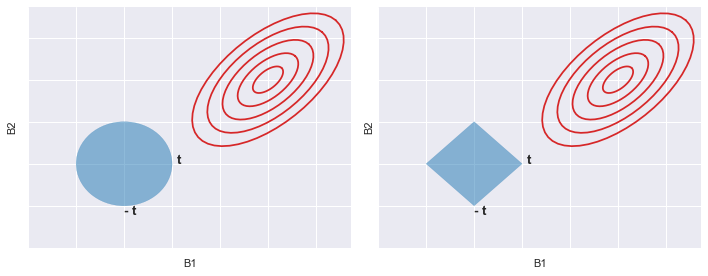

In [13]:
rr.plot_constrain_regions(cmd = 'ridge_vs_lasso')

## <font color='#28B463'>Lasso Estimator

<br>
While ridge regression scales all of the coefficients by the same proportion (a constant factor), Lasso instead shrinks these coefficients toward zero translates the coefficients towards zero by a constant value, and sets them to zero if they are "sufficiently" small.

<br>
$
    \quad  
    \begin{align}
        \hat{\boldsymbol{\beta}}_\boldsymbol{L \ j} = 
        \begin{cases}
            0 \quad & \quad \boldsymbol{k} > \ \mid \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} \ \mid
            \\
            \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} - sign \ (\boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y}) \ \boldsymbol{k}
            \quad & \quad \boldsymbol{k} \leq \ \mid \ \boldsymbol{\mathbf{X}_j^{\top}}\mathbf{Y} \ \mid
        \end{cases} 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
            & [\textbf{E4}] 
    \end{align}
$

<br>
Generally speaking, as the regularization parameter $ \ k \ $ increases :

<ul style="list-style-type:square">
    <li>
        the bias increases
    </li>
    <br>
    <li>
         the variance decreases
    </li>
</ul>


## <font color='#28B463'>Choice of the Regularization Parameter

<br>
In addition to fitting the parameters, choosing the regularization parameter is also a fundamental part of using Lasso. Selecting it well is essential to the performance of Lasso since it controls the strength of shrinkage and variable selection, which (in moderation) can improve both prediction and interpretability. 

<br>
However, <b>if the regularization becomes too strong, important variables may be left out of the model</b> and coefficients may be shrunk excessively, which can harm both the predictive capacity and the inferences drawn about the system being studied. 

<br>
<b>LARS</b> is unique in this regard as it <b>generates complete regularization paths</b> which makes determining the optimal value of the regularization parameter much more straightforward. With other methods, <b>cross-validation is typically used to select the parameter</b>. Additionally, a variety of heuristics related to choosing the regularization and optimization parameters are often used in order to attempt to improve performance further.


### <font color='#28B463'>Solution Trace

<br>
In a similar way as in the case of Ridge regression, we can achieve an estimate $ \ \hat{\boldsymbol{\beta}}_\boldsymbol{L} \ $ by executing the algorithm multiple times, each time using a different$ \  k_i \ $ from a predetermined set, and examine a visual representation of the solution path to select the smallest value of the regularization parameter for which a reasonable compromise has been reached between bias and variance, regularization and complexity, underfitting and overfitting etc.


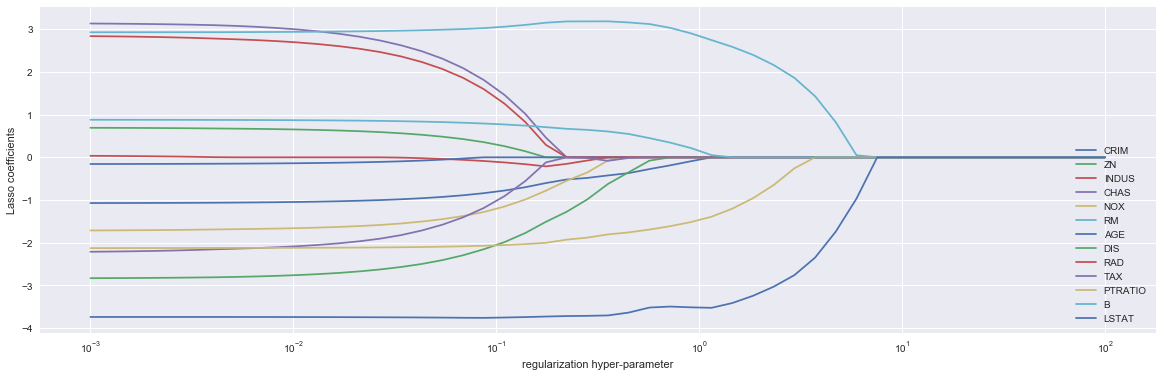

In [14]:
n_alphas = 50
alphas = np.logspace(-3, 2, n_alphas)

rr.plot_coefficients(
    df = df_std, 
    features = features, 
    target = target, 
    linear_model_name = 'Lasso', 
    linear_model_args = {'fit_intercept' :True}, 
    alphas = alphas
)

### <font color='#28B463'>Variance Inflation Factor

<br>

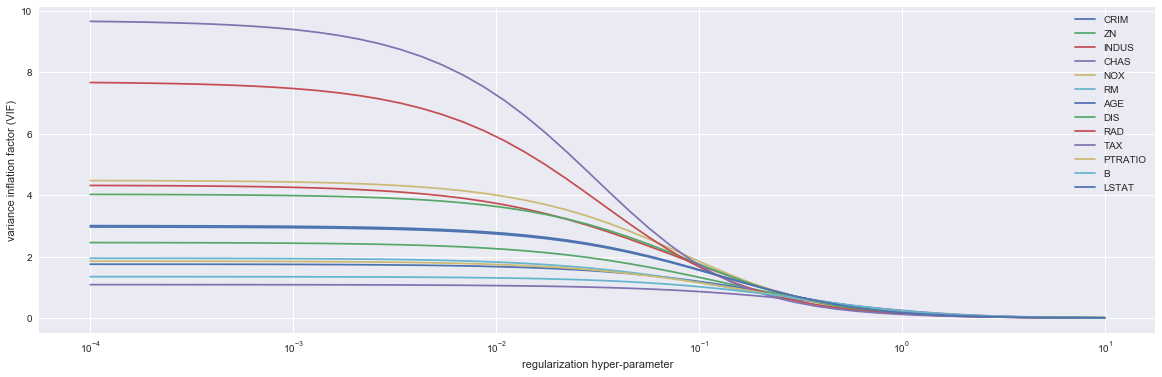

In [15]:
n_alphas = 50
alphas = np.logspace(-4, 1, n_alphas)

rr.plot_vif(df = df_std, features = features, alphas = alphas)

### <font color='#28B463'>Grid-Search Cross Validation

<br>

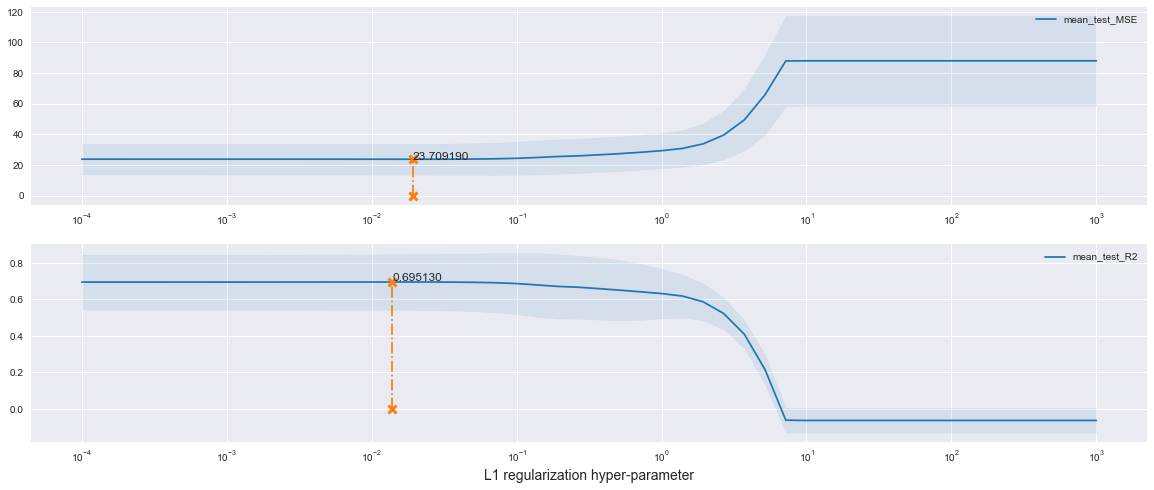

In [16]:
n_alphas = 50
alphas = np.logspace(-4, 3, n_alphas)

scoring_list = {
    'MSE' : 'neg_mean_squared_error', 
    'R2' : 'r2'}

grid = GridSearchCV(
    estimator = lm.Lasso(fit_intercept = True), 
    param_grid = {'alpha' : alphas}, 
    scoring = scoring_list,  
    refit = 'MSE',
    cv = 10
)

grid.fit(df_std[features], df_std[target])
grid_results = grid.cv_results_

rr.plot_gridsearch_cv(
    param_name = 'param_alpha', 
    param = alphas, 
    scoring_list = scoring_list, 
    grid_results = grid_results,
    plot_args = {'xscale' : 'log', 'xlabel' : 'L1 regularization hyper-parameter'}
)


In [17]:
alpha = 10**(0)

lasso_list = [
    { 'df' : df_train,     'linear_model_name' : 'Lasso', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'original' },
    #{ 'df' : df_sk,     'linear_model_name' : 'Lasso', 
    # 'linear_model_args' : {'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'linear_model_name' : 'Lasso', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'centered' },
    { 'df' : df_std, 'linear_model_name' : 'Lasso', 
     'linear_model_args' : {'alpha' : alpha, 'fit_intercept' :True}, 'note' : 'standardized'}    
]

results_lasso = pd.DataFrame()

for l in lasso_list:
    results_temp = uc.compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        linear_model_name = l['linear_model_name'], 
        linear_model_args = l['linear_model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results_lasso = results_lasso.append(results_temp).reset_index(drop = True)

#print(results_lasso[['note','intercept', 'err_test']])

## <font color='#28B463'>Impact on the intercept

<br>

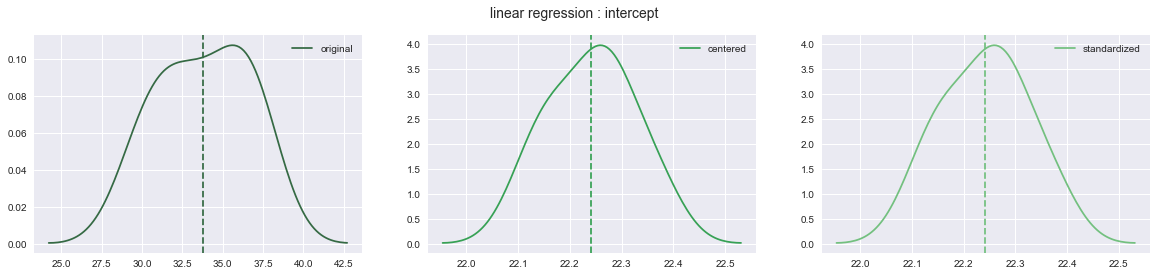

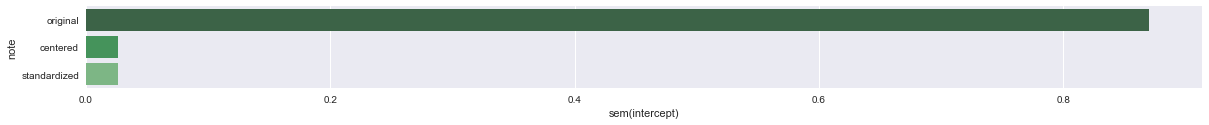

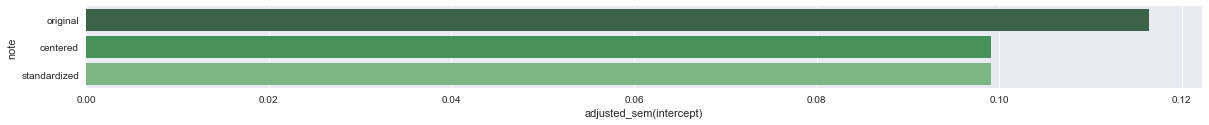

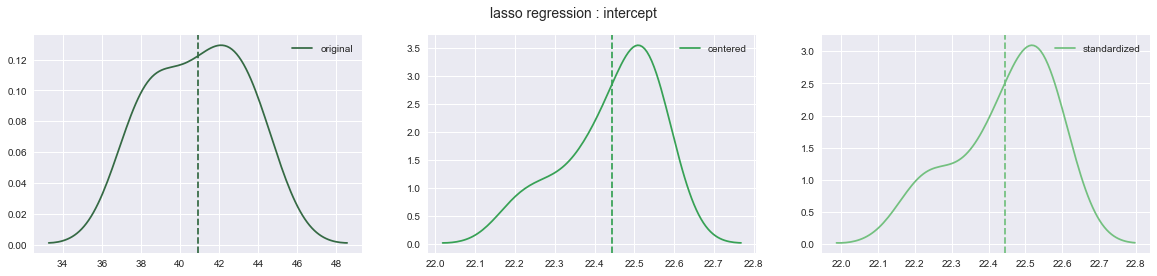

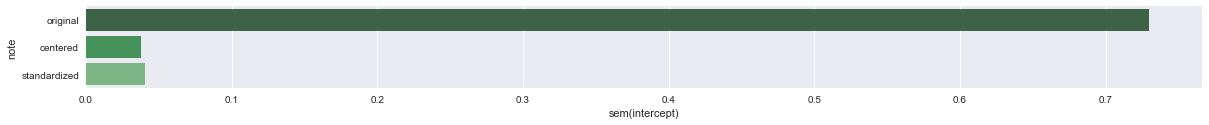

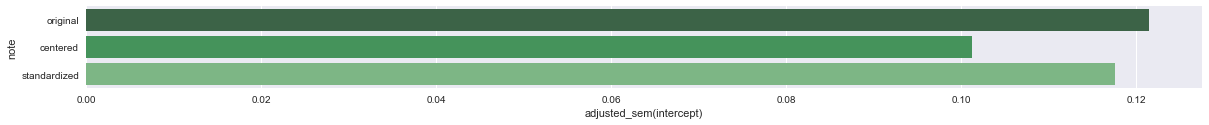

In [18]:
up.plot_across_discriminant(
    df = results, 
    cols = ['intercept'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

up.plot_across_discriminant(
    df = results_lasso, 
    cols = ['intercept'], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'lasso regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

## <font color='#28B463'>Impact on the regression coefficients of the transformed features

<br>

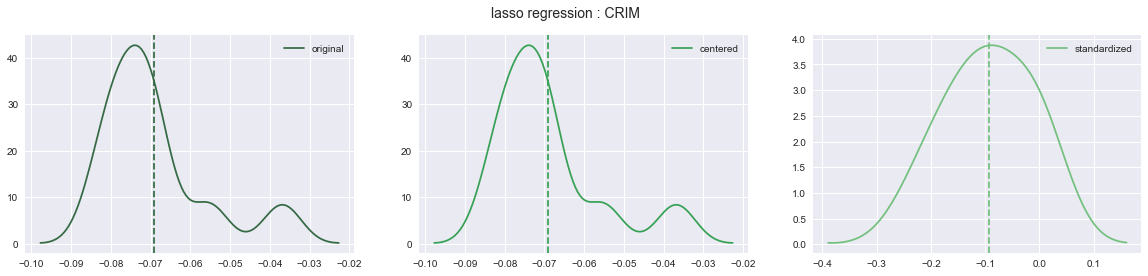

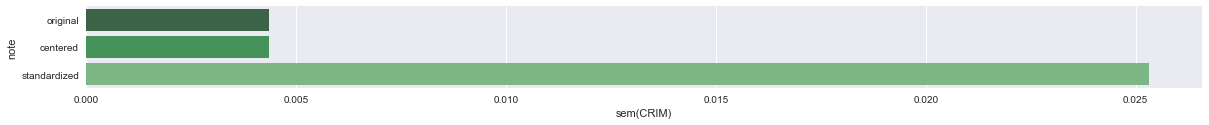

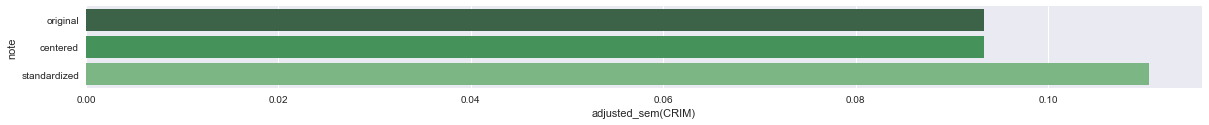

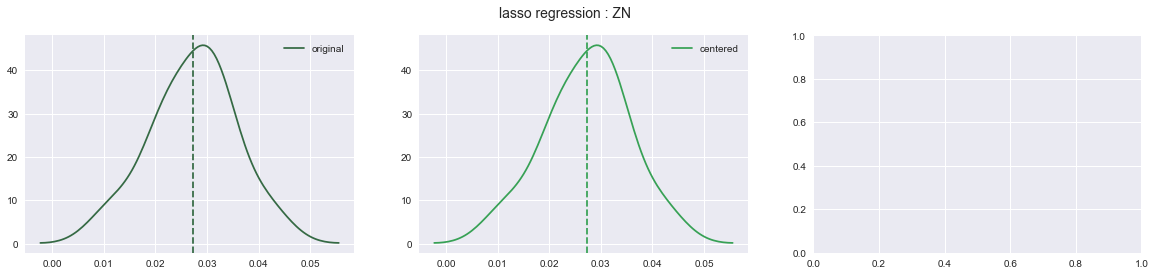

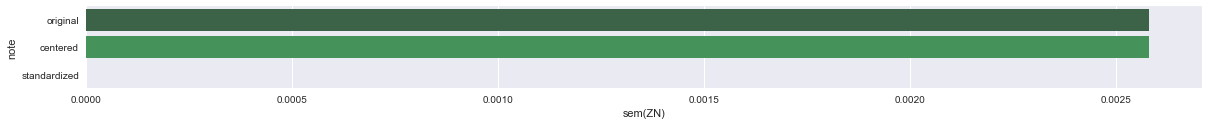

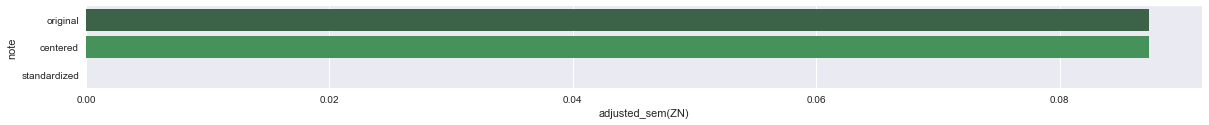

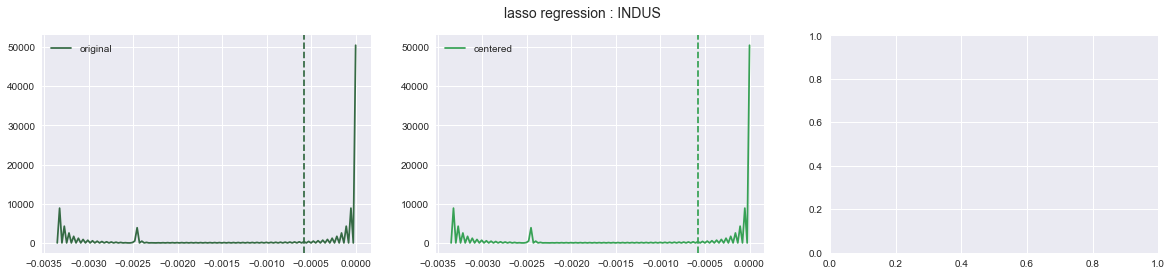

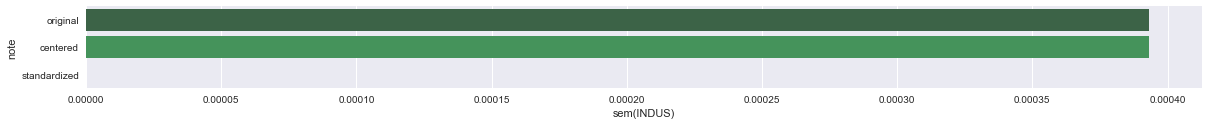

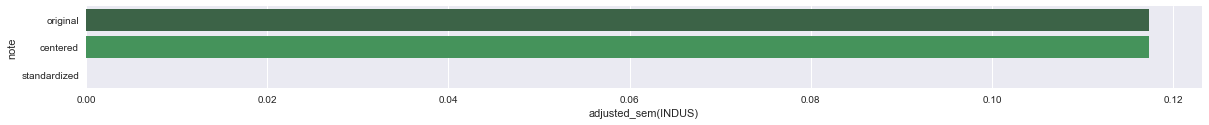

In [19]:
visualized_features = included_features[:3]

up.plot_across_discriminant(
    df = results_lasso, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'lasso regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)    
    

## <font color='#28B463'>Impact on the regression coefficients of the non-transformed features

<br>

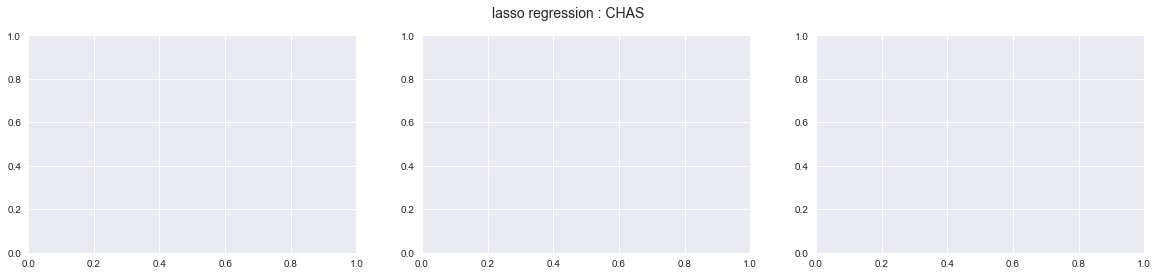

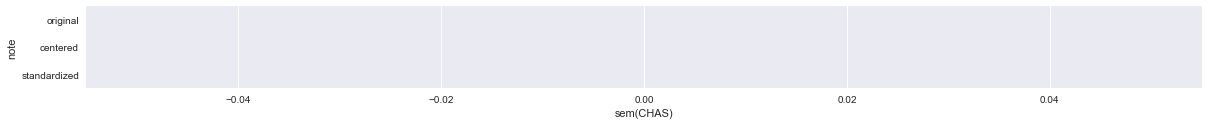

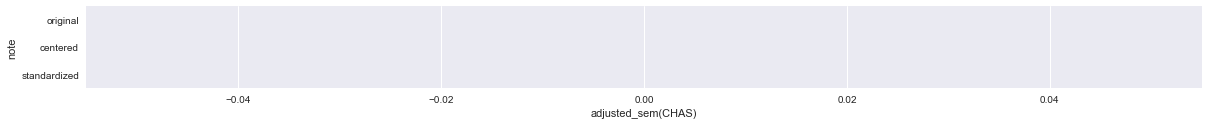

In [20]:
visualized_features = excluded_features

up.plot_across_discriminant(
    df = results_lasso, 
    cols = visualized_features, 
    discriminant_col = 'note', 
    plot_args = {'title' : 'lasso regression', 'skewness' : False, 'normality' : False}, 
    distplot = True,
    sem      = True, 
    adj_sem  = True,
    mean     = False
)

    

## <font color='#28B463'>Impact on the regression score

<br>

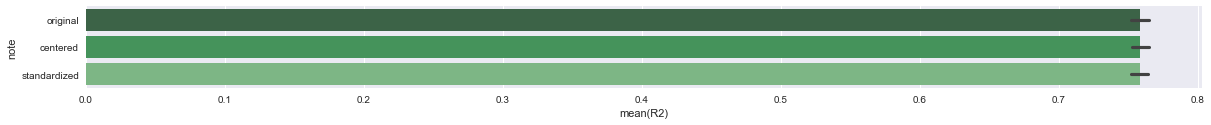

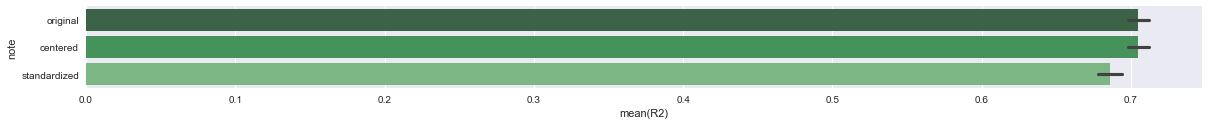

                                            linear regression                                                 lasso regression

R2 mean (original)       :                             0.7581     R2 mean (original)       :                            0.7044
R2 mean (centered)       :                             0.7581     R2 mean (centered)       :                            0.7044
R2 mean (standardized)   :                             0.7581     R2 mean (standardized)   :                            0.6858


In [21]:
metric = 'R2'

up.plot_across_discriminant(
    df = results, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'linear regression', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)

up.plot_across_discriminant(
    df = results_lasso, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'lasso regression', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


template = "{0:>61}{1:>65}" 
print(template.format('linear regression', 'lasso regression'))
print()

discriminant_values = results['note'].unique().tolist() 
template = "{0:25}:{1:>35}     {2:25}:{3:34}" 
for (d_index,d) in enumerate(discriminant_values):
    label_1 = ('{0} mean ({1})'.format(metric, d))
    label_2 = ('{0} mean ({1})'.format(metric, d))
    
    criteria = (results_lasso['note'] == d)
    
    subset_1 = results[criteria][metric]    
    subset_2 = results_lasso[criteria][metric]
    
    print(template.format(label_1, round(subset_1.mean(), 4), label_2, round(subset_2.mean(), 4)))


## <font color='#28B463'>Considerations

<br>
In this notebook we have seen that L1-regularization produces interpretable models (like subset selection) while exhibiting the stability of ridge regression; at this point a question may come to mind : why shouldn't we always choose Lasso over Ridge ?

<br>
Neither ridge regression nor the lasso will universally dominate the other. In general, <b>we might expect Ridge to perform better when the response is assumed to be a function of many predictors</b>, all the coefficients having roughly equal size, while <b>Lasso might outperform the former when we assume the response to have only a relatively small number of predictors with substantial coefficients</b>.

<br>
That being said, we know that the number of influential predictors (in relation to the response) is never known a priori for real data sets; a technique such as cross-validation is typically used in order to determine which approach is better on a particular data set.

<br>
<font color='#28B463'><b>Limitations and further extensions</b></font>

<br>
Although the lasso has shown success in many situations, it has some limitations. Consider the following three scenarios :

<br>
<ul style="list-style-type:square">
    <li>
        in the $ \ p > n \ $ case, lasso selects at most $ \ n \ $ variables before it saturates, because of the nature of the
        convex optimization problem; this seems to be a limiting feature for a variable selection method. Moreover, lasso is not
        well defined unless the bound on the L1-norm of the coefficients is smaller than a certain value
    </li>
    <br>
    <li>
        if there is a group of variables among which the pairwise correlations are very high, then lasso tends to select only
        one variable from the group and does not care which one is selected
    </li>
    <br>
    <li>
         for usual $ p < n \ $ situations, if there are high correlations between predictors, it has been empirically observed
         that the prediction performance of lasso is dominated by ridge regression
    </li>
</ul>

<br>
A number of lasso variants have been created in order to remedy certain limitations of the original technique and to make the method more useful for particular problems; almost all of these techniques focus on respecting or utilizing different types of dependencies among the covariates.

<br>
<b>Elastic Net</b> regularization adds an additional ridge regression-like penalty which improves performance when the number of predictors is larger than the sample size, allows the method to select strongly correlated variables together, and improves overall prediction accuracy.

<br>
<b>Group Lasso</b> allows groups of related covariates to be selected as a single unit, which can be useful in settings where it does not make sense to include some covariates without others. Further extensions of group lasso to perform variable selection within individual groups (sparse group lasso) and to allow overlap between groups (overlap group lasso) have also been developed.

<br>
<b>Fused Lasso</b> can account for the spatial or temporal characteristics of a problem, resulting in estimates that better match the structure of the system being studied.


## <font color='#28B463'>References

<br>
<ul style="list-style-type:square">
    <li>
        Wikipedia - Lasso <br>
        https://en.wikipedia.org/wiki/Tikhonov_regularization
    </li>
    <br>
    <li>
         Stanford University - Robert Tibshirani - Regression Shrinkage and Selection via the Lasso <br>
         http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=460FC4389D543251766F55D4ECA9433C?doi=10.1.1.35.7574&rep=rep1&type=pdf
    </li>
    <br>
    <li>
        Yale University - Taylor B. Arnold - Intro to Lasso Regression <br>
        http://statsmaths.github.io/stat612/lectures/lec17/lecture17.pdf
    </li>
    <br>
    <li>
        Wikipedia - Subderivative <br>
        https://en.wikipedia.org/wiki/Subderivative        
    </li>
    <br>
    <li>
        University of Massachusetts - Anna Liu - Shrinkage method II : Lasso <br>
        http://people.math.umass.edu/~anna/stat697F/Chapter6_part2.pdf
    </li>
    <br>
    <li>
        Alex Lenail - What is the difference between Ridge Regression, the LASSO, and ElasticNet? <br>
        https://blog.alexlenail.me/what-is-the-difference-between-ridge-regression-the-lasso-and-elasticnet-ec19c71c9028
    </li>
    <br>
    <li>
        Stanford University - Zou and Hastie - Regularization and variable selection via the elastic net <br>
        https://web.stanford.edu/~hastie/Papers/B67.2%20(2005)%20301-320%20Zou%20&%20Hastie.pdf
    </li>
</ul>
